<a href="https://colab.research.google.com/github/oleksandr-g-rock/How_to_create_confusion_matrix/blob/main/How_to_create_a_confusion_matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification flowers and confusion_matrix






---

https://www.kaggle.com/alxmamaev/flowers-recognition

---

Need upload to server this dataset https://www.kaggle.com/alxmamaev/flowers-recognition

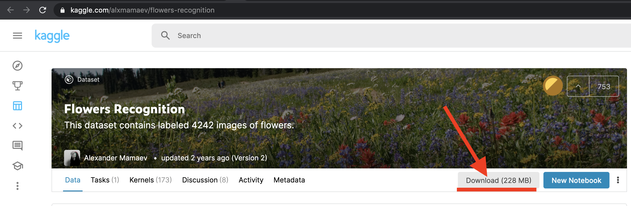

---

Using InceptionV3, transfer learning, fine tuning, data augmentation, data vizualization etc.

---

Just open this notebook in https://colab.research.google.com/

Upload dataset which you download from https://www.kaggle.com/alxmamaev/flowers-recognition

Run this notebook (like on screenashot below)


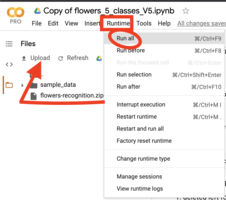

Just relax and see how the code works :)
---



Need unzip folder

In [ ]:
!jar xvf /content/archive.zip

Need run bash script which:
1. deleted left folder flowers in new directory
2. will sorted all data (images for each classes) to folders: train (80% images) and val (20% images). 

In [ ]:
!git clone https://raw.githubusercontent.com/oleksandr-g-rock/flower_classification/main/flowers_sort.sh
!chmod 777 flowers_sort.sh
!cat flowers_sort.sh
!bash flowers_sort.sh

add testing folder and move 10 files from val from each class

In [ ]:
!mkdir /content/flowers/testing
!cp -r /content/flowers/train/* /content/flowers/testing/

In [ ]:
!ls /content/flowers/testing/ | while read -r NAME; do cd /content/flowers/testing/"${NAME}" && rm -rf * ; done

In [ ]:
!ls /content/flowers/val/ | while read -r NAME; do cd /content/flowers/val/"${NAME}" && ls | tail -10 | xargs -I{} sudo mv {} /content/flowers/testing/"${NAME}"/ ; done

Download modules

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy import loadtxt
import tensorflow.keras
from PIL import Image, ImageOps
%matplotlib inline

Set image size & batch size

In [ ]:
image_size = 256
batch_size = 32

# Create image generator

In [ ]:
# folders with train dir & val dir
train_dir = '/content/flowers/train/'
test_dir = '/content/flowers/val/'
testing_dir = '/content/flowers/testing/'
input_shape = (image_size, image_size, 3)

Create image data generator for train data

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                              samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = True, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.2, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.2)

Check generator

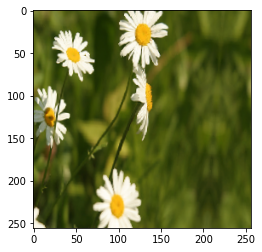

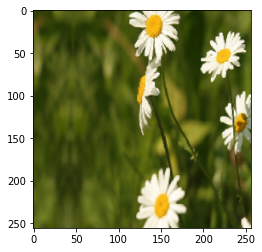

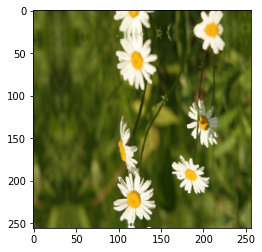

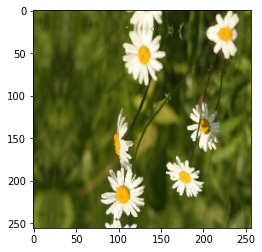

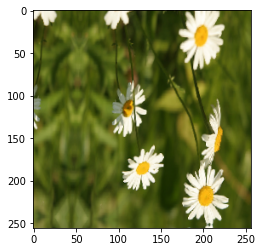

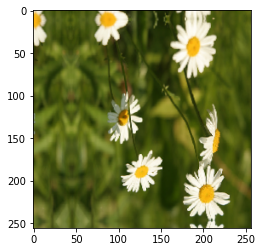

In [ ]:
img_path = '/content/flowers/train/daisy/174131220_c853df1287.jpg'
img = image.load_img(img_path, target_size=(image_size, image_size))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 6 == 0:
        break
plt.show()

Setting train generator

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 2935 images belonging to 5 classes.


Setting test generator without data augmentation

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 675 images belonging to 5 classes.


Setting tesing generator without data augmentation

In [ ]:
testing_datagen = ImageDataGenerator(rescale=1. / 255)

testing_generator = testing_datagen.flow_from_directory(
    testing_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')

Found 50 images belonging to 5 classes.


Print count classes

In [ ]:
train_generator.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

Graph count images per classes "train"



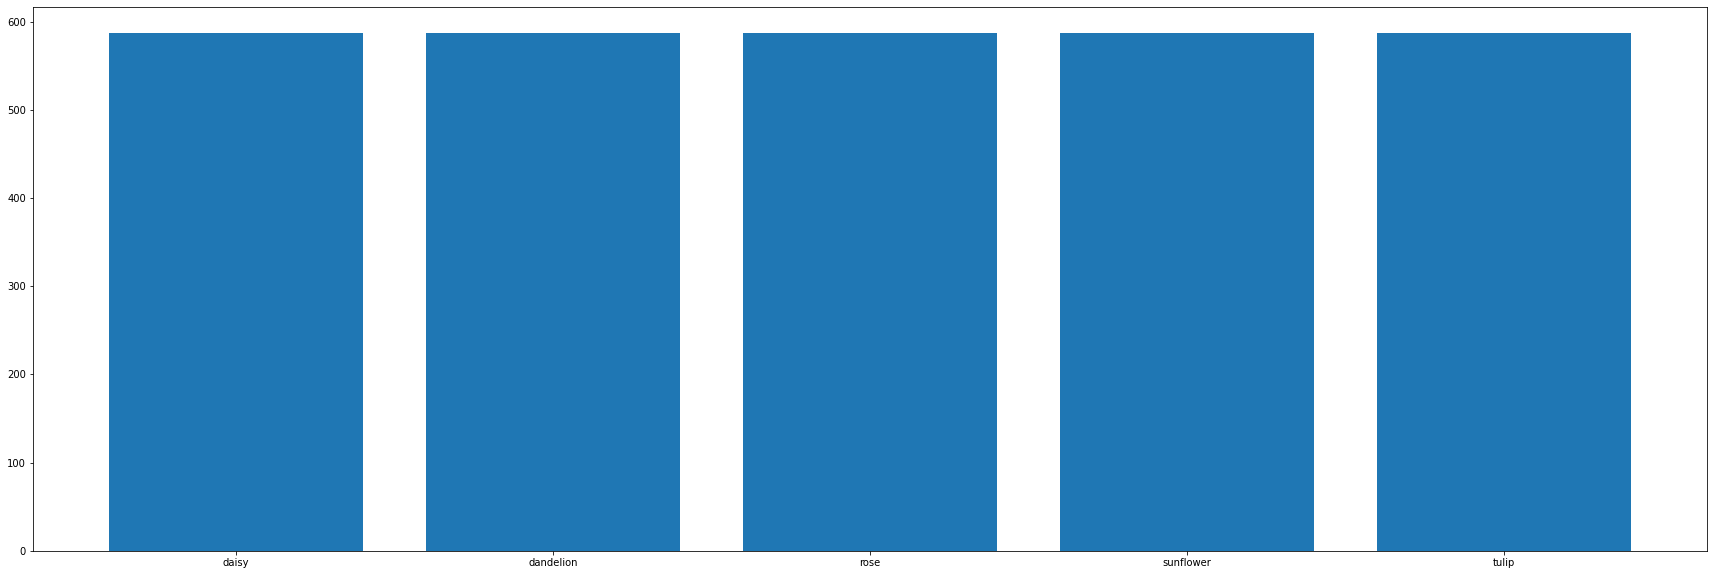

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
cls_train = train_generator.classes
from collections import OrderedDict
classes = list(train_generator.class_indices.keys())
num_values = []
unique, counts = np.unique(cls_train, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
for i in range(5):
    num_values.append(valdict[i])
plt.figure(figsize=(30,10))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.show()   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


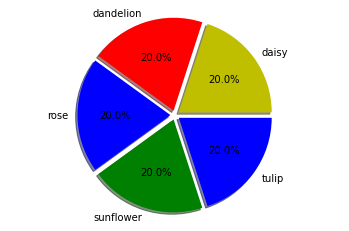

In [ ]:
import matplotlib.pyplot as plt
goal_types = list(train_generator.class_indices.keys())
unique, counts = np.unique(cls_train, return_counts=True)
goals = [(counts)]
colors = ['y','r','b','g','b']
plt.pie(goals, labels = goal_types, colors=colors ,shadow = True, explode = (0.05, 0.05, 0.05, 0.05, 0.05), autopct = '%1.1f%%')
plt.axis('equal')
plt.show()

Graph count images per classes "test"

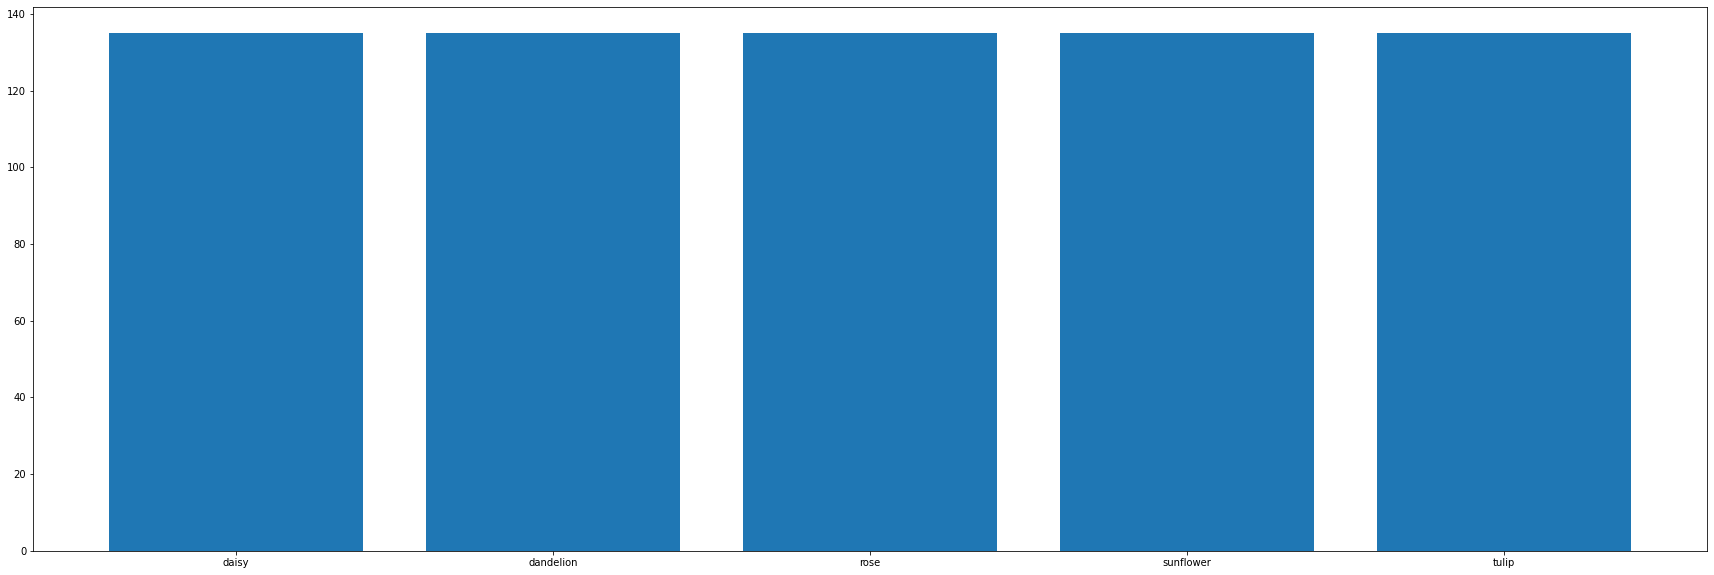

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
cls_test = test_generator.classes
from collections import OrderedDict


classes = list(test_generator.class_indices.keys())
num_values = []
unique, counts = np.unique(cls_test, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
for i in range(5):
    num_values.append(valdict[i])
plt.figure(figsize=(30,10))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.show() 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  


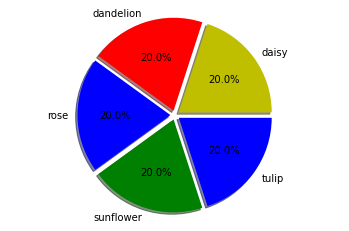

In [ ]:
import matplotlib.pyplot as plt

goal_types = list(test_generator.class_indices.keys())
unique, counts = np.unique(cls_test, return_counts=True)
goals = [(counts)]
colors = ['y','r','b','g','b']

plt.pie(goals, labels = goal_types, colors=colors ,shadow = True, explode = (0.05, 0.05, 0.05, 0.05, 0.05), autopct = '%1.1f%%')
plt.axis('equal')

plt.show()

# Download InceptionV3 model

In [ ]:
pretrained_model = InceptionV3(weights='imagenet', include_top=False)
pretrained_model.summary()

"Frozen" all weights pretrained models 

In [ ]:
pretrained_model.trainable = False
pretrained_model.summary()

# Created main layers for end inceptionV3 model

In [ ]:
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = Activation('relu')(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=predictions)

View all model before training

In [ ]:
model.summary()

# Train a composite neural network based on InceptionV3

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

filepath="inceptionv3_best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks_list = [checkpoint, learning_rate_reduction]

steps_per_epoch = 40
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=7,
    verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/7

Epoch 00001: val_loss improved from inf to 1.96843, saving model to inceptionv3_best.h5
40/40 - 23s - loss: 1.1065 - accuracy: 0.6090 - val_loss: 1.9684 - val_accuracy: 0.4625
Epoch 2/7

Epoch 00002: val_loss improved from 1.96843 to 0.67347, saving model to inceptionv3_best.h5
40/40 - 22s - loss: 0.8210 - accuracy: 0.7109 - val_loss: 0.6735 - val_accuracy: 0.7625
Epoch 3/7

Epoch 00003: val_loss improved from 0.67347 to 0.56233, saving model to inceptionv3_best.h5
40/40 - 22s - loss: 0.6638 - accuracy: 0.7577 - val_loss: 0.5623 - val_accuracy: 0.8313
Epoch 4/7

Epoch 00004: val_loss improved from 0.56233 to 0.55099, saving model to inceptionv3_best.h5
40/40 - 22s - loss: 0.6902 - accuracy: 0.7459 - val_loss: 0.5510 - val_accuracy: 0.7750
Epoch 5/7

Epoch 00005: val_loss did not improve from 0.55099
40/40 - 21s - loss: 0.5773 - accuracy: 0.7859 - val_loss: 0.9436 - val_accuracy: 0.7312
Epoch 6/7

Epo

Test Score

In [ ]:
test_score = model.evaluate_generator(testing_generator, batch_size)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

Instructions for updating:
Please use Model.evaluate, which supports generators.
[INFO] accuracy: 75.00%
[INFO] Loss:  0.6306620240211487


Visualize the history of network learning for testing data in confusion matrix format

Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

       daisy       0.91      1.00      0.95        10
   dandelion       1.00      0.80      0.89        10
        rose       0.78      0.70      0.74        10
   sunflower       0.83      1.00      0.91        10
       tulip       0.80      0.80      0.80        10

    accuracy                           0.86        50
   macro avg       0.86      0.86      0.86        50
weighted avg       0.86      0.86      0.86        50



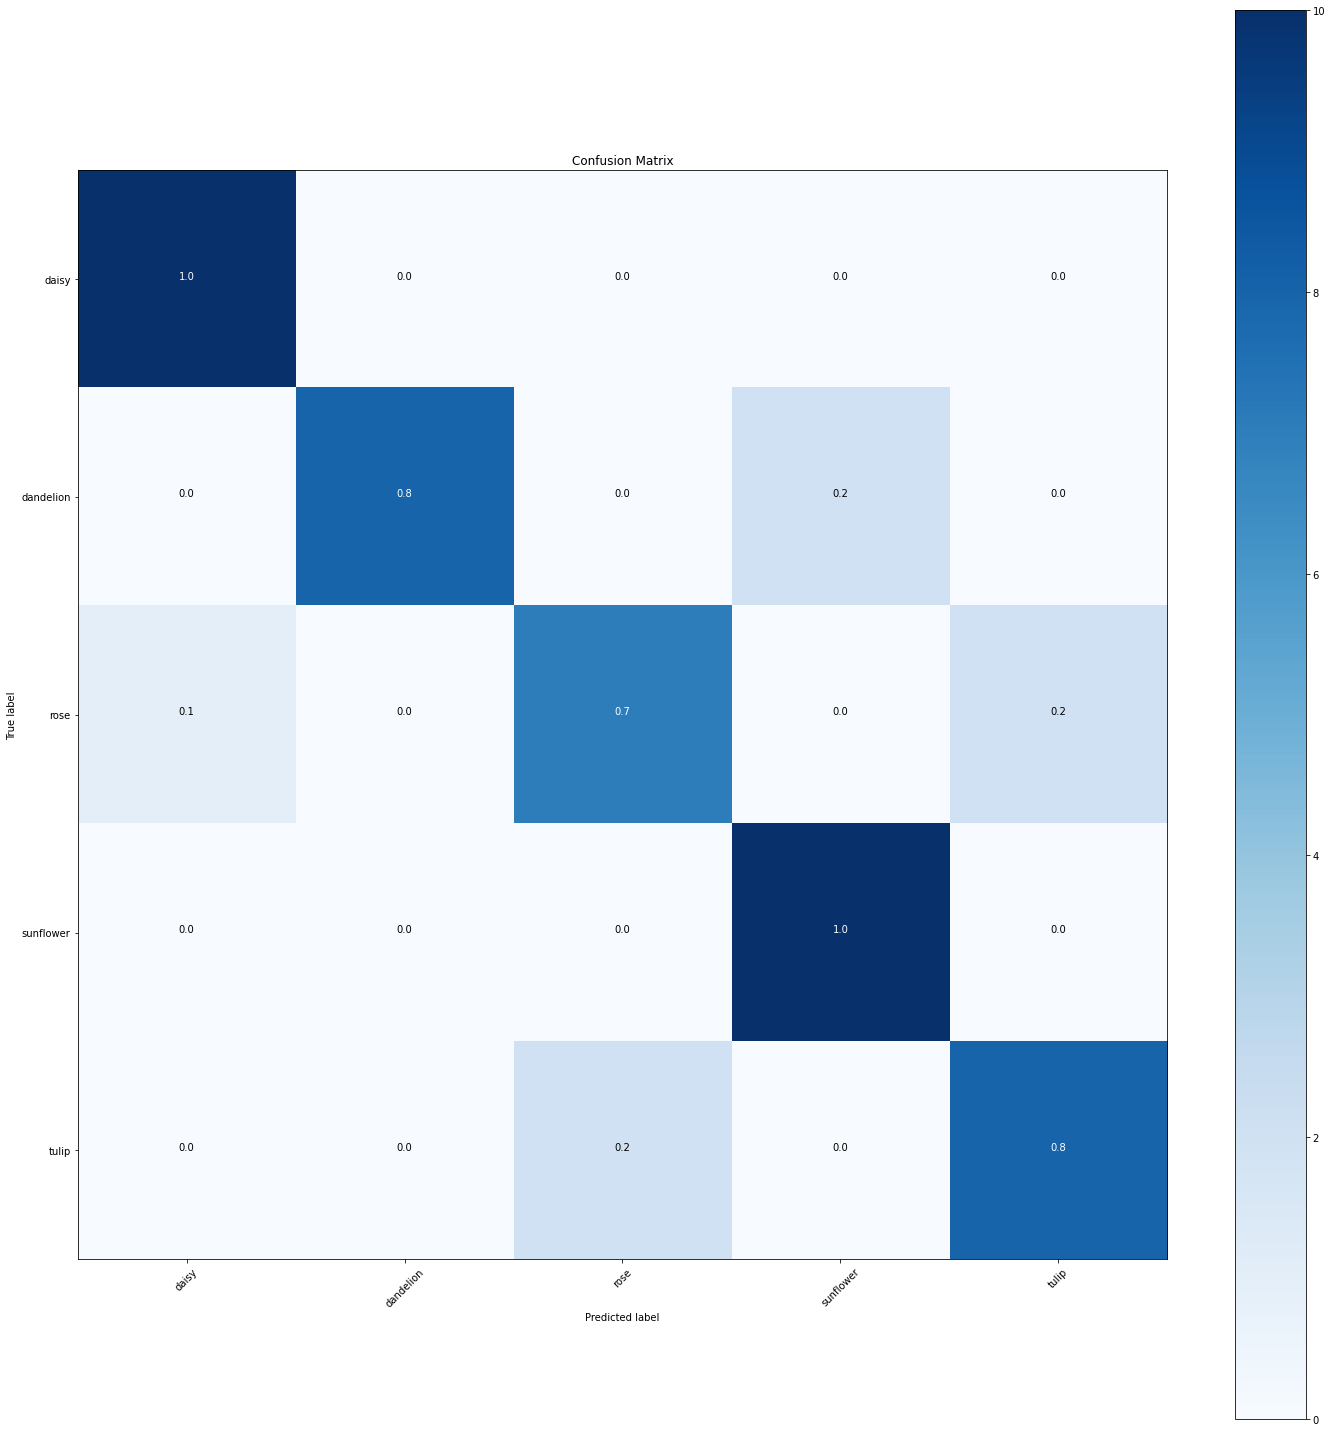

In [ ]:
#Plot the confusion matrix. Set Normalize = True/False

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False

target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

# print(target_names)

#Confution Matrix 

Y_pred = model.predict_generator(testing_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(testing_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

#Print Classification Report
print('Classification Report')
print(classification_report(testing_generator.classes, y_pred, target_names=target_names))

Visualize the history of network learning: accuracy, loss in graphs.




Text(0.5, 1.0, 'Accuracy Curves')

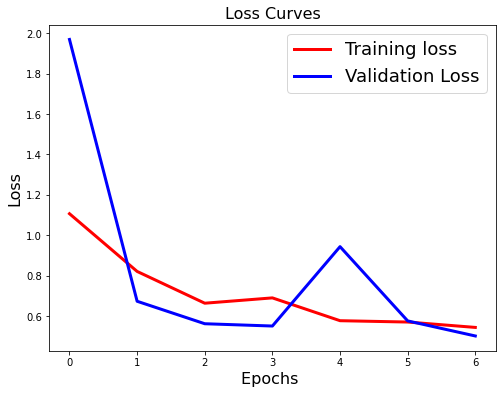

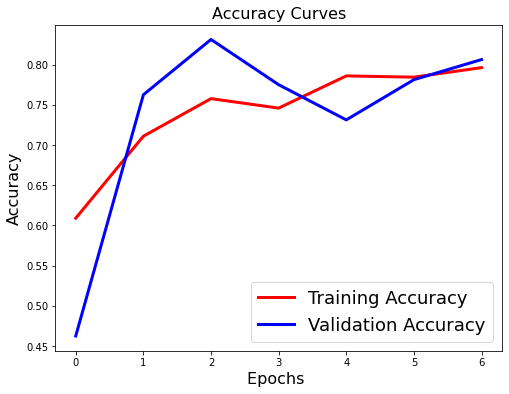

In [ ]:
#Plot the Graph

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

# Fine tuning convolutional layers Inception V3

Download the best weights

In [ ]:
model.load_weights("inceptionv3_best.h5")

Defrost the last 2 blocks of Inception V3

In [ ]:
pretrained_model.trainable = False
for layer in model.layers[:290]:
   layer.trainable = False
for layer in model.layers[290:]:
   layer.trainable = True


Compile a network with defrosted layers. And start learning

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

filepath="inceptionv3_fine_tuned.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, learning_rate_reduction]


steps_per_epoch = 32
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=5,
    verbose=2)

Epoch 1/5

Epoch 00001: val_loss improved from inf to 1.79596, saving model to inceptionv3_fine_tuned.h5
32/32 - 19s - loss: 0.8389 - accuracy: 0.7383 - val_loss: 1.7960 - val_accuracy: 0.6438
Epoch 2/5

Epoch 00002: val_loss improved from 1.79596 to 0.58095, saving model to inceptionv3_fine_tuned.h5
32/32 - 17s - loss: 0.6180 - accuracy: 0.7783 - val_loss: 0.5809 - val_accuracy: 0.7750
Epoch 3/5

Epoch 00003: val_loss improved from 0.58095 to 0.49789, saving model to inceptionv3_fine_tuned.h5
32/32 - 18s - loss: 0.5028 - accuracy: 0.8164 - val_loss: 0.4979 - val_accuracy: 0.8562
Epoch 4/5

Epoch 00004: val_loss did not improve from 0.49789
32/32 - 17s - loss: 0.4860 - accuracy: 0.8291 - val_loss: 1.0080 - val_accuracy: 0.7500
Epoch 5/5

Epoch 00005: val_loss improved from 0.49789 to 0.38672, saving model to inceptionv3_fine_tuned.h5
32/32 - 17s - loss: 0.4511 - accuracy: 0.8232 - val_loss: 0.3867 - val_accuracy: 0.8625


Test Score

In [ ]:
test_score = model.evaluate_generator(testing_generator, batch_size)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 
print("[INFO] Loss: ",test_score[0])

[INFO] accuracy: 86.00%
[INFO] Loss:  0.3067568242549896


Visualize the history of network learning: accuracy, loss in graphs.




Text(0.5, 1.0, 'Accuracy Curves')

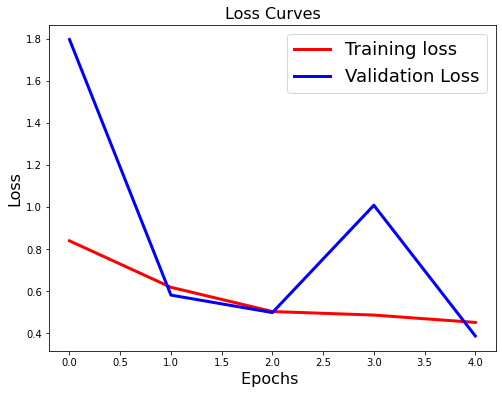

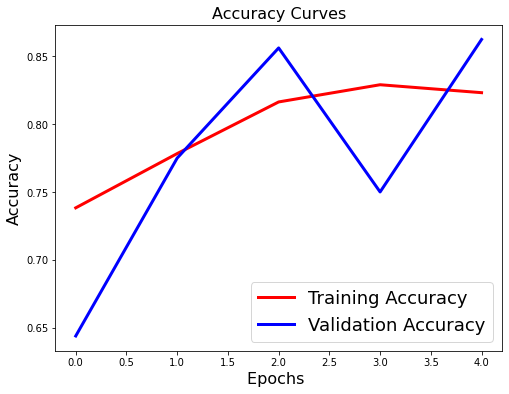

In [ ]:
#Plot the Graph

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

Visualize the history of network learning for testing data in confusion matrix format

Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

       daisy       1.00      1.00      1.00        10
   dandelion       0.77      1.00      0.87        10
        rose       0.80      0.80      0.80        10
   sunflower       0.80      0.80      0.80        10
       tulip       1.00      0.70      0.82        10

    accuracy                           0.86        50
   macro avg       0.87      0.86      0.86        50
weighted avg       0.87      0.86      0.86        50



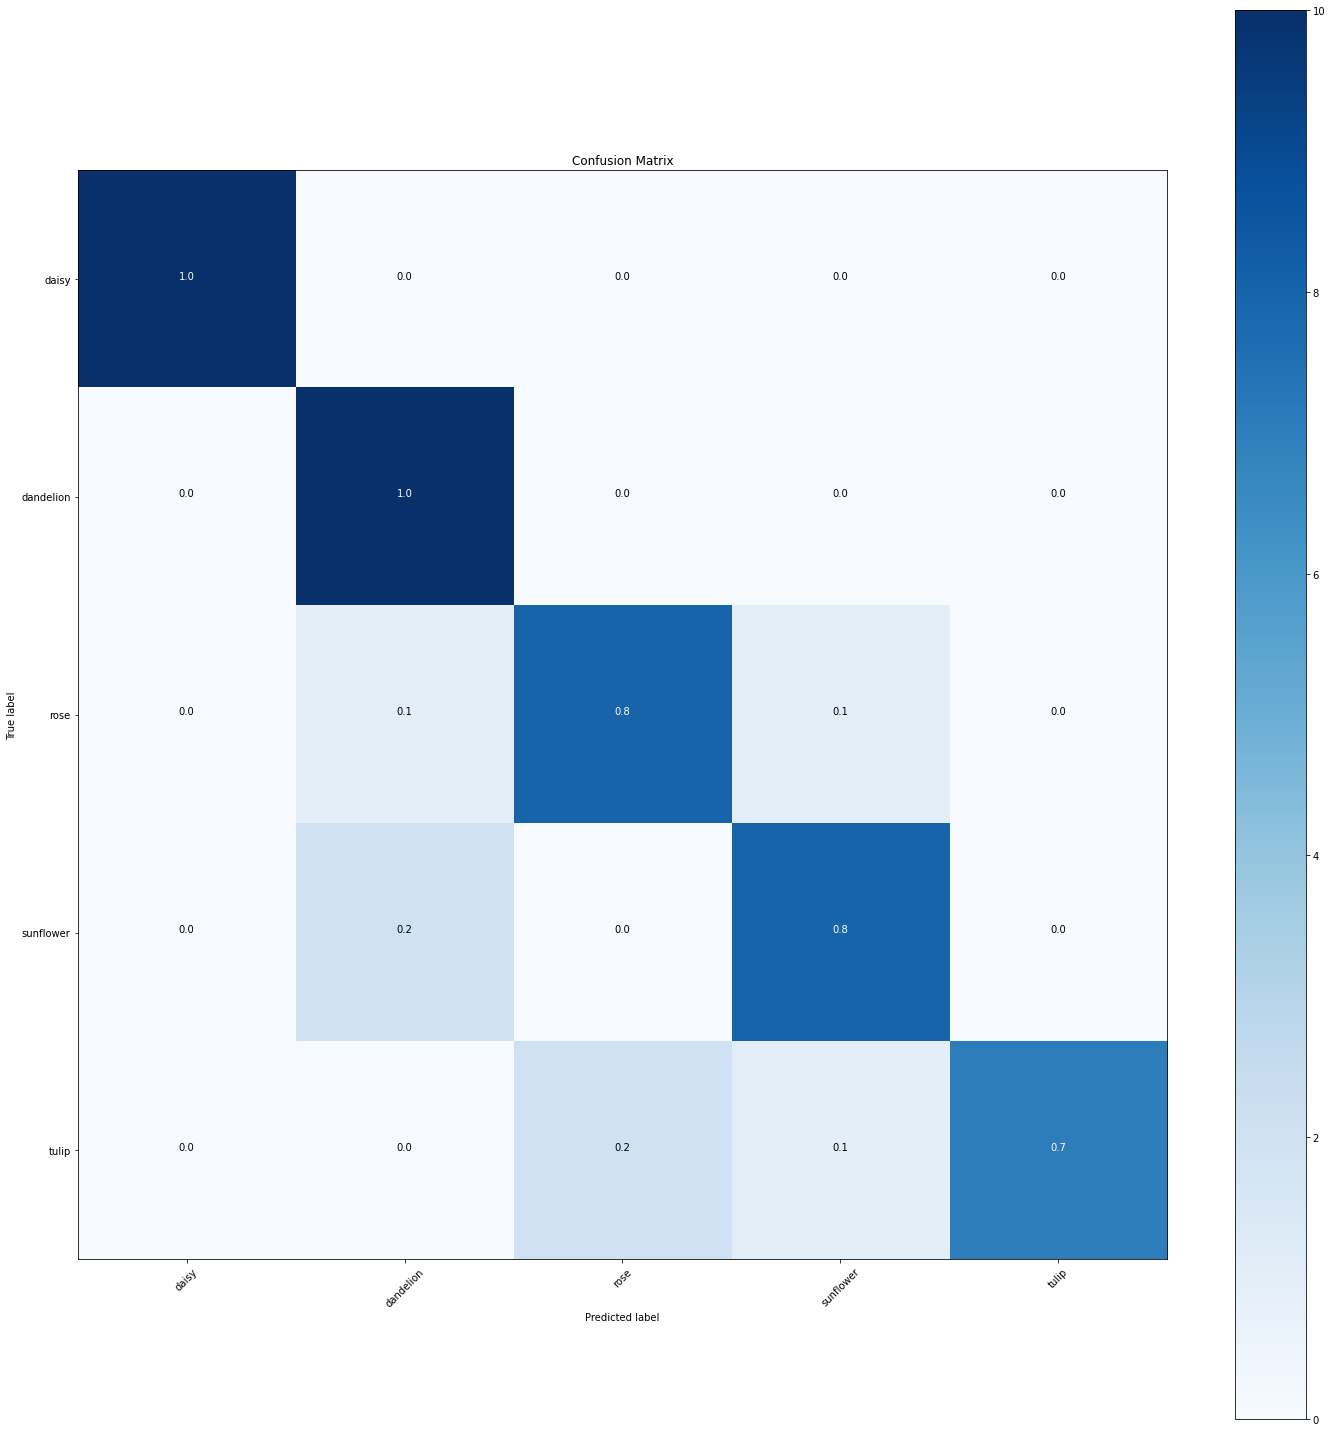

In [ ]:
#Plot the confusion matrix. Set Normalize = True/False

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False

target_names = []
for key in train_generator.class_indices:
    target_names.append(key)

# print(target_names)

#Confution Matrix 

Y_pred = model.predict_generator(testing_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(testing_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

#Print Classification Report
print('Classification Report')
print(classification_report(testing_generator.classes, y_pred, target_names=target_names))

Testing model and download the best weights

In [ ]:
# Load the model

model = tensorflow.keras.models.load_model('/content/inceptionv3_fine_tuned.h5')


Upload random photo from internet with flowers

In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/a/a3/Iglesia_de_Nuestra_Se%C3%B1ora_de_La_Blanca%2C_Cardej%C3%B3n%2C_Espa%C3%B1a%2C_2012-09-01%2C_DD_02_cropped.JPG/2880px-Iglesia_de_Nuestra_Se%C3%B1ora_de_La_Blanca%2C_Cardej%C3%B3n%2C_Espa%C3%B1a%2C_2012-09-01%2C_DD_02_cropped.JPG

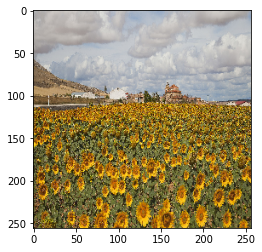

In [ ]:
img_path = '/content/2880px-Iglesia_de_Nuestra_Señora_de_La_Blanca,_Cardejón,_España,_2012-09-01,_DD_02_cropped.JPG'

img = image.load_img(img_path, target_size=(image_size, image_size))
plt.imshow(img)
plt.show()

In [ ]:
x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

In [ ]:
prediction = model.predict(x)

In [ ]:
prediction

array([[0.01171284, 0.03889041, 0.00431254, 0.7818625 , 0.16322175]],
      dtype=float32)

List classes with numbers of classes:

'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4

In [ ]:
classes = np.argmax(prediction, axis = 1)
print(classes)

[3]
